Source: https://pub.aimind.so/credit-card-fraud-detection-using-tensor-flow-2-0-fcc6859ea4e9

In [2]:
import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.config import list_physical_devices

print(f"Tensorflow version: `{tf.__version__}`")
print(f"CUDNN version: `{tf_build_info.build_info['cudnn_version']}`")
print(f"CUDA version: `{tf_build_info.build_info['cuda_version']}`")
print(f"Num GPUs Available: {len(list_physical_devices('GPU'))}")

Python Version: `3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


<a href="https://colab.research.google.com/github/siddharthapramanik771/CreditCardFraudDetectionML/blob/main/Credit_card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary packages 

In [3]:
# %pip install tensorflow==2.10.1 numpy=1.26.4 pandas scikit-learn imblearn matplotlib seaborn

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Getting Relevant Data

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
base_path = 'dataset'
data_path = os.path.join(base_path, 'fraudTest.csv')
# data_path = os.path.join(base_path, 'fraudTrain.csv')

data = pd.read_csv(data_path, index_col=0)

In [7]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

# Data Analysis


In [8]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [9]:
data.isnull().any().sum()

0

no mising data

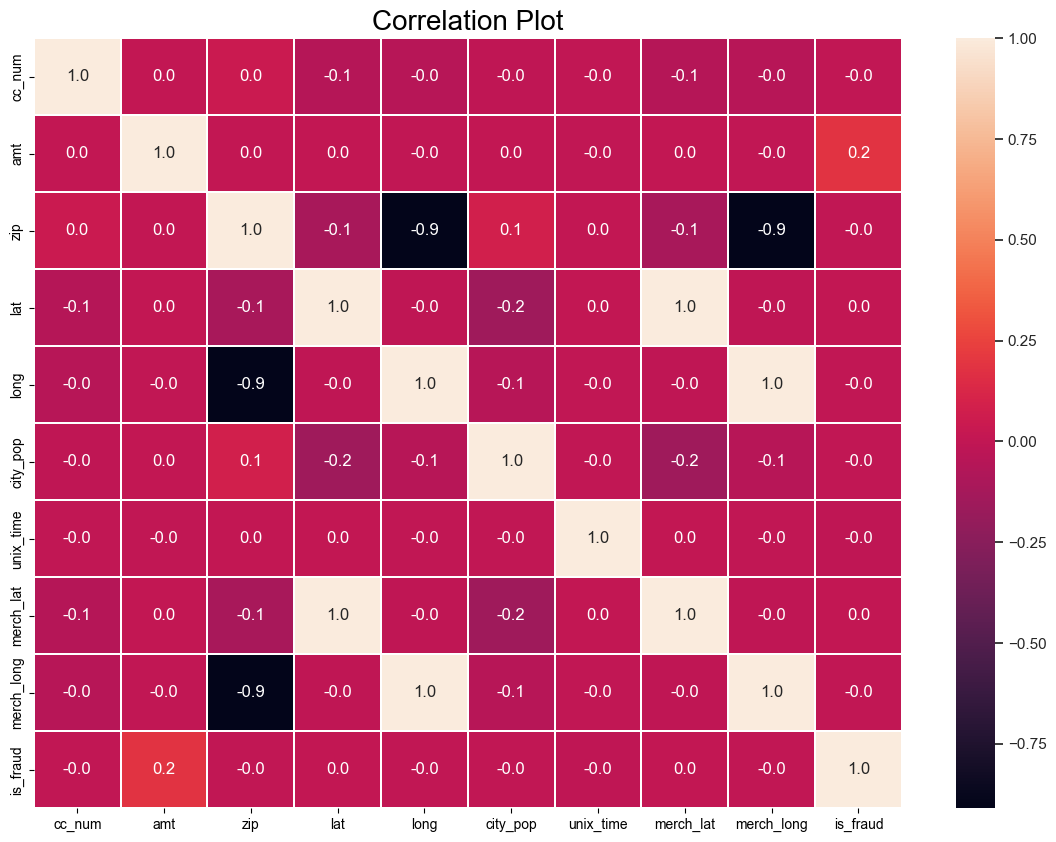

In [10]:
float_types_columns = []
for col in data:
    try:
        data[col].astype('float')
        float_types_columns.append(col)
    except:
        continue

plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data[float_types_columns].corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

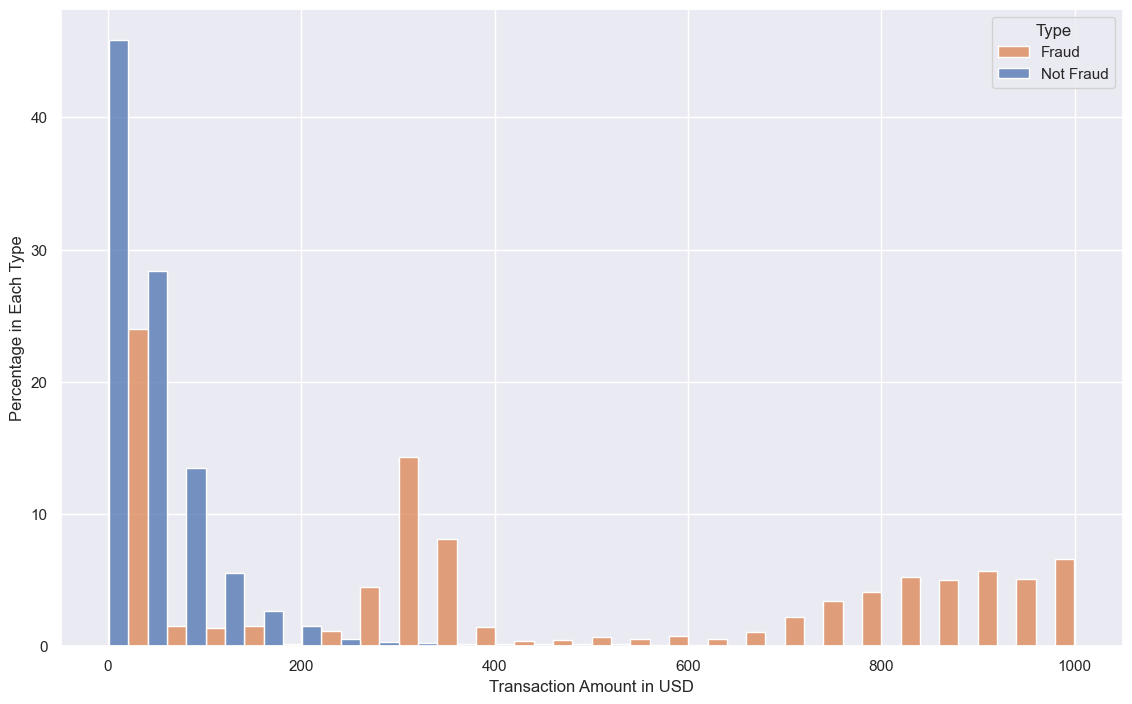

In [11]:
df = data
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

<Axes: xlabel='gender', ylabel='count'>

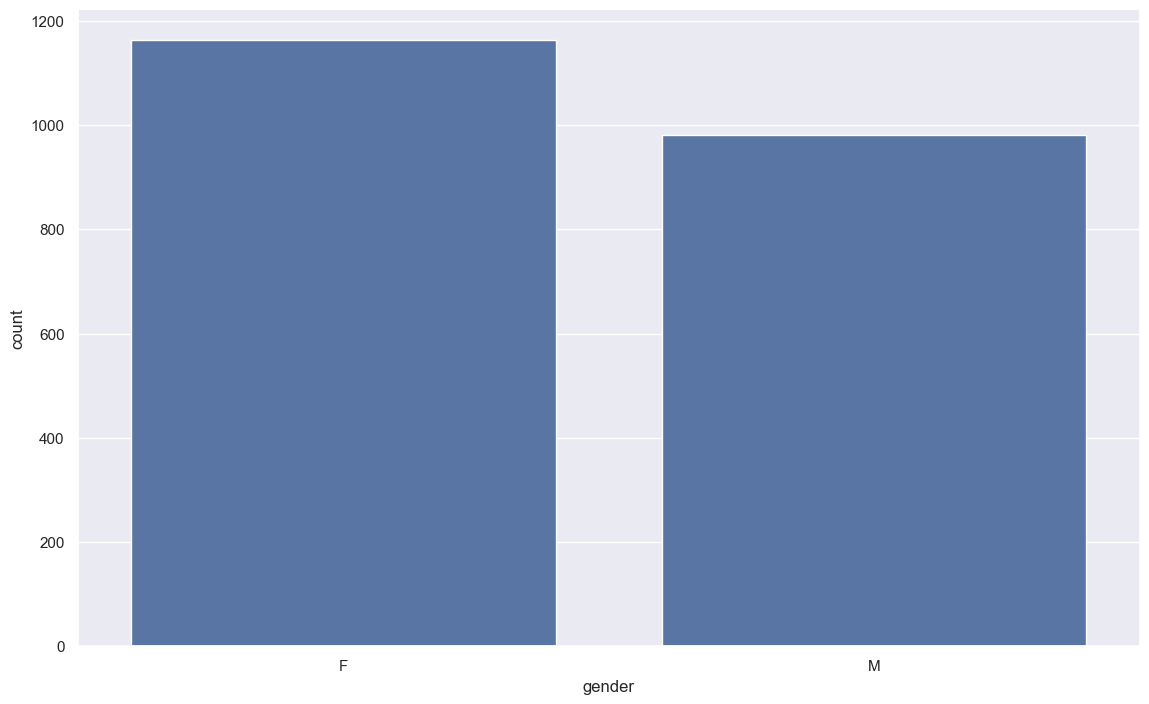

In [12]:
sns.countplot(x="gender",data=df[df["is_fraud"]==1])

<Axes: xlabel='age_group', ylabel='count'>

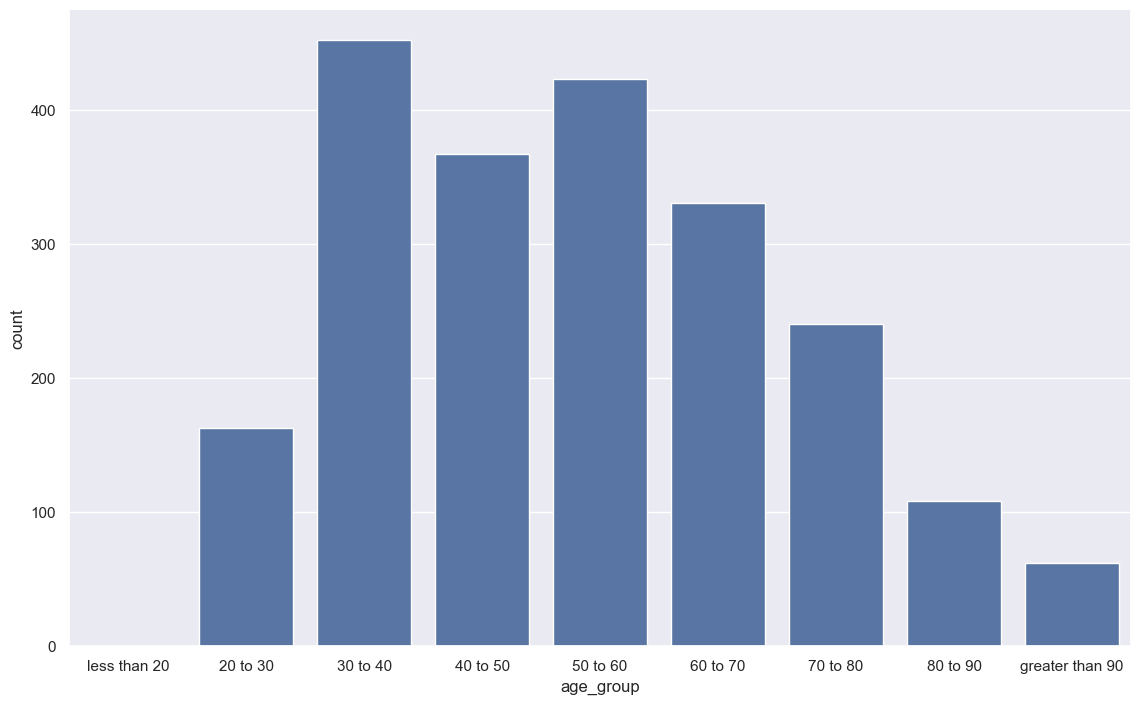

In [13]:
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.Timestamp.today() - data['dob']).dt.days // 365

# Create age groups
def age_category(age):
    if age < 20:
        return "less than 20"
    elif age < 30:
        return "20 to 30"
    elif age < 40:
        return "30 to 40"
    elif age < 50:
        return "40 to 50"
    elif age < 60:
        return "50 to 60"
    elif age < 70:
        return "60 to 70"
    elif age < 80:
        return "70 to 80"
    elif age < 90:
        return "80 to 90"
    else:
        return "greater than 90"

# Create age group column
data['age_group'] = data['age'].apply(age_category)

order = ["less than 20","20 to 30","30 to 40","40 to 50","50 to 60","60 to 70","70 to 80","80 to 90","greater than 90"]
sns.countplot(x="age_group",data=df[df["is_fraud"]==1], order = order)

In [14]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

# Calculate distances and create new column
data['dist'] = haversine_distance(
    data['lat'], 
    data['long'], 
    data['merch_lat'], 
    data['merch_long']
)

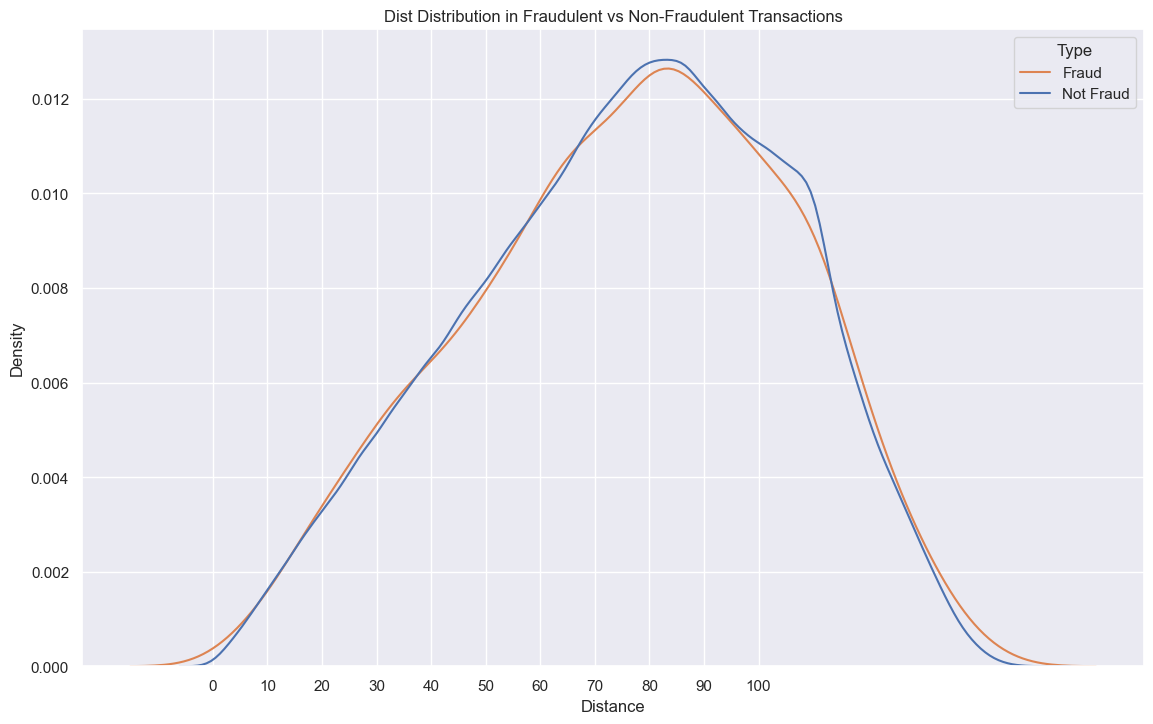

In [15]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

<Axes: xlabel='state', ylabel='count'>

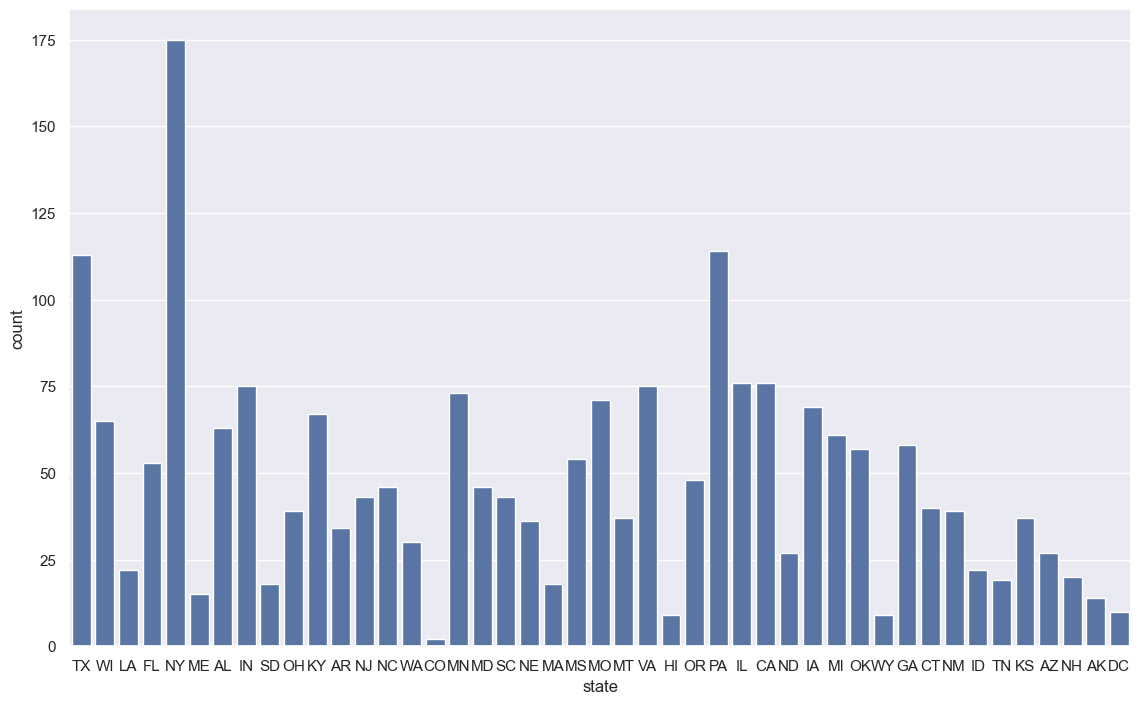

In [16]:
sns.countplot(x="state",data=df[df["is_fraud"]==1])

# Data Pre-processing

In [17]:
data.shape

(555719, 25)

In [18]:
data = data.drop(["lat","long","merch_lat","merch_long"], axis=1)
drop_cols = ["cc_num","merchant","first","last","street","trans_num","city_pop","job","unix_time","trans_num","city","zip"]
data = data.drop(columns = drop_cols, axis=1)

In [19]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'dob',
       'is_fraud', 'age', 'age_group', 'dist'],
      dtype='object')

In [20]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [21]:
non_fraud = data[data['is_fraud']==0]
fraud = data[data['is_fraud']==1]

In [22]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(2145, 10)

In [23]:
data = pd.concat([non_fraud, fraud])

In [24]:
data['is_fraud'].value_counts()

is_fraud
0    2145
1    2145
Name: count, dtype: int64

In [25]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
def data_processing(data,encoding=True):
  if encoding:
    print('One Hot Encoding is applied')
    data = pd.concat([data,pd.get_dummies(data["gender"]),pd.get_dummies(data["age_group"]),pd.get_dummies(data["state"]),pd.get_dummies(data["category"])],axis=1)
    data = data.drop(["trans_date_trans_time", "dob", "gender","age_group","state","category"], axis=1)
  y = data["is_fraud"]
  x = data.drop(["is_fraud"], axis = 1)   
  # Standardization
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)
  # If the training data imbalanced we’ll address this using Synthetic Minority Oversampling Technique (SMOTE). 
  # It is an oversampling technique that creates artificial minority class samples. 
  # In our case, it creates synthetic fraud instances and so corrects the imbalance in our dataset.
  # y_train.value_counts()
  if y_train.value_counts()[0] != y_train.value_counts()[1]:
    print('SMOTE is applied')
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
  return X_train,y_train,X_test,y_test,data  


In [27]:
X_train, y_train, X_test, y_test, processed_data = data_processing(data)
y_train.value_counts()

One Hot Encoding is applied
SMOTE is applied


is_fraud
1    1720
0    1720
Name: count, dtype: int64

In [28]:
features = processed_data.columns.drop('is_fraud')
features

Index(['amt', 'age', 'dist', 'F', 'M', '20 to 30', '30 to 40', '40 to 50',
       '50 to 60', '60 to 70', '70 to 80', '80 to 90', 'greater than 90', 'AK',
       'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'HI', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY', 'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
       'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')

In [29]:
X_train.shape

(3440, 77)

In [30]:
len(features)

77

In [31]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'dob',
       'is_fraud', 'age', 'age_group', 'dist'],
      dtype='object')

# Model Building

## using scikit-learn

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score,mean_absolute_error
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model_impl = RandomForestClassifier()
# X_train = X_train.reshape(X_train.shape[0],1)
# X_test = X_test.reshape(X_test.shape[0],1)
model_impl.fit(X_train,y_train)
pred_train=model_impl.predict(X_train)
pred_test=model_impl.predict(X_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)
confusionMatrix = confusion_matrix(y_test,pred_test)
classificationReport = classification_report(y_test,pred_test)
mae = mean_absolute_error(y_train,pred_train)
# print("Model Implemented: ", 'Decision_tree')
print("Accuracy on Training Set: ", accuracy_train)
print('Accuracy on Validation Set: ', accuracy_test)
print('Mean absolute error: ',mae)
print('Confusion Matrix\n', confusionMatrix)
print('Classification Report\n', classificationReport)

(3440, 77) (3440,) (858, 77) (858,)
Accuracy on Training Set:  1.0
Accuracy on Validation Set:  0.9393939393939394
Mean absolute error:  0.0
Confusion Matrix
 [[402  23]
 [ 29 404]]
Classification Report
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       425
           1       0.95      0.93      0.94       433

    accuracy                           0.94       858
   macro avg       0.94      0.94      0.94       858
weighted avg       0.94      0.94      0.94       858



## using Tensorflow 

In [33]:
epochs = 50
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())

model.add(Conv1D(32, 2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 76, 64)            192       
                                                                 
 batch_normalization (BatchN  (None, 76, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 32)            4128      
                                                                 
 dropout (Dropout)           (None, 75, 32)            0         
                                                                 
 dense (Dense)               (None, 75, 64)            2112      
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                        

In [35]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [36]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1,callbacks = [callback])

Epoch 1/50
108/108 [==============================] - 4s 15ms/step - loss: 0.5425 - accuracy: 0.7262 - val_loss: 0.5414 - val_accuracy: 0.7494
Epoch 2/50
108/108 [==============================] - 1s 12ms/step - loss: 0.3391 - accuracy: 0.8413 - val_loss: 0.4192 - val_accuracy: 0.8275
Epoch 3/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2936 - accuracy: 0.8552 - val_loss: 0.3448 - val_accuracy: 0.8531
Epoch 4/50
108/108 [==============================] - 1s 13ms/step - loss: 0.2728 - accuracy: 0.8625 - val_loss: 0.3011 - val_accuracy: 0.8625
Epoch 5/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2508 - accuracy: 0.8733 - val_loss: 0.3043 - val_accuracy: 0.8636
Epoch 6/50
108/108 [==============================] - 1s 13ms/step - loss: 0.2379 - accuracy: 0.8837 - val_loss: 0.2935 - val_accuracy: 0.8788
Epoch 7/50
108/108 [==============================] - 1s 13ms/step - loss: 0.2331 - accuracy: 0.8852 - val_loss: 0.3015 - val_accuracy: 0.8753

In [37]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

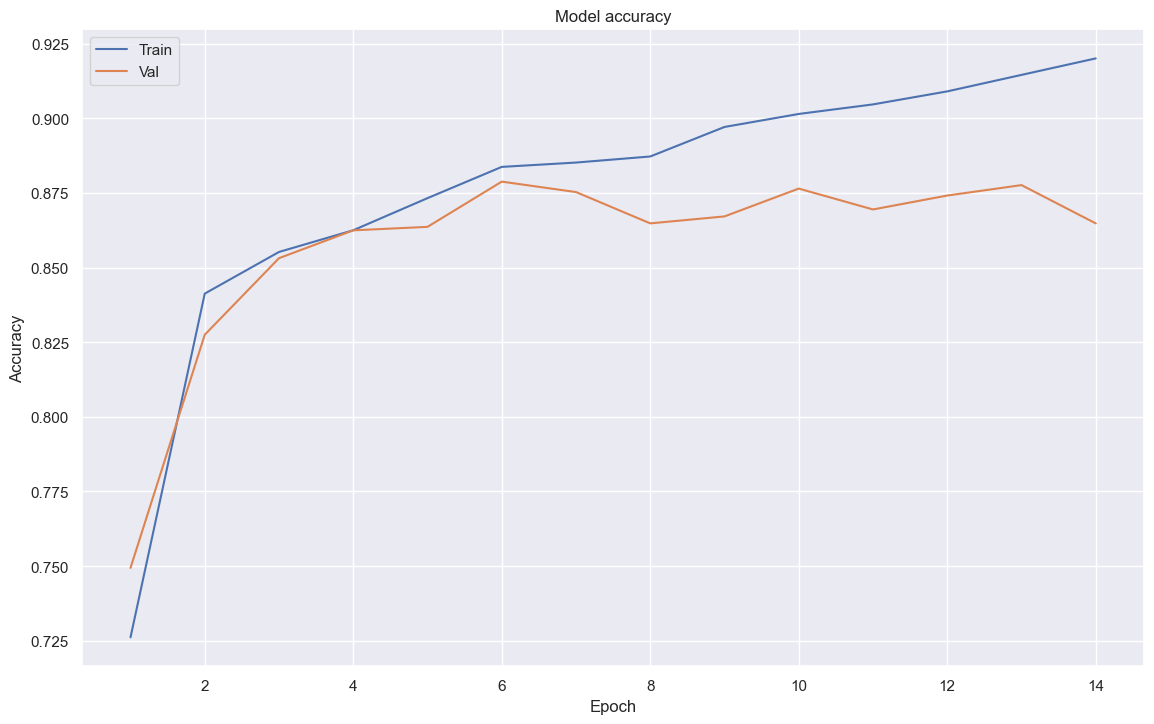

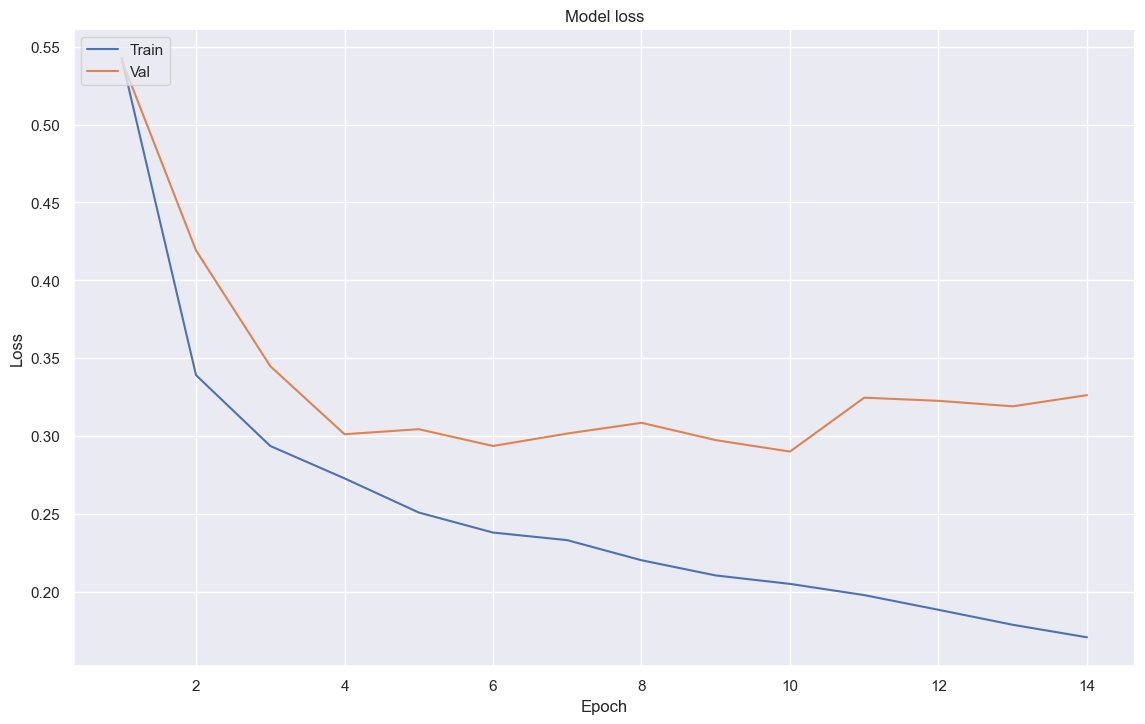

In [38]:
plot_learningCurve(history,len(history.epoch))

In [39]:
y_predict= model.predict(X_test)

27/27 [==============================] - 0s 6ms/step


In [40]:
y_predict = np.round(y_predict).astype(int)

In [41]:
classificationReport = classification_report(y_test,y_predict)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       425
           1       0.87      0.89      0.88       433

    accuracy                           0.88       858
   macro avg       0.88      0.88      0.88       858
weighted avg       0.88      0.88      0.88       858



In [42]:
confusionMatrix = confusion_matrix(y_test, y_predict)
confusionMatrix

array([[367,  58],
       [ 48, 385]], dtype=int64)

# XAI Techniques

## SHAP

In [43]:
import shap

In [44]:
def SHAP(X_train, X_test, idx=1):
    if X_train.shape[-1] != 1:
        X_train = np.expand_dims(X_train, axis=-1)
    if X_test.shape[-1] != 1:
        X_test = np.expand_dims(X_test, axis=-1)
    
    # For DeepExplainer, we need to create a background dataset
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    
    # Initialize DeepExplainer
    explainer = shap.DeepExplainer(model, background)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test[:idx+2])

    return explainer, shap_values

In [45]:
# Call the function
idx = 100
explainer, shap_values = SHAP(X_train, X_test, idx)

d:\ThongLai\OneDrive - University of Huddersfield\FYP\code\Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI\.venv_xai_fraud_detection\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
d:\ThongLai\OneDrive - University of Huddersfield\FYP\code\Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI\.venv_xai_fraud_detection\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


### Visualization
[SHAP Plots Explained](https://www.youtube.com/playlist?list=PLpoCVQU4m6j9HDOzRBL4nX4eol9DrZ3Kd)

#### Summary Plot

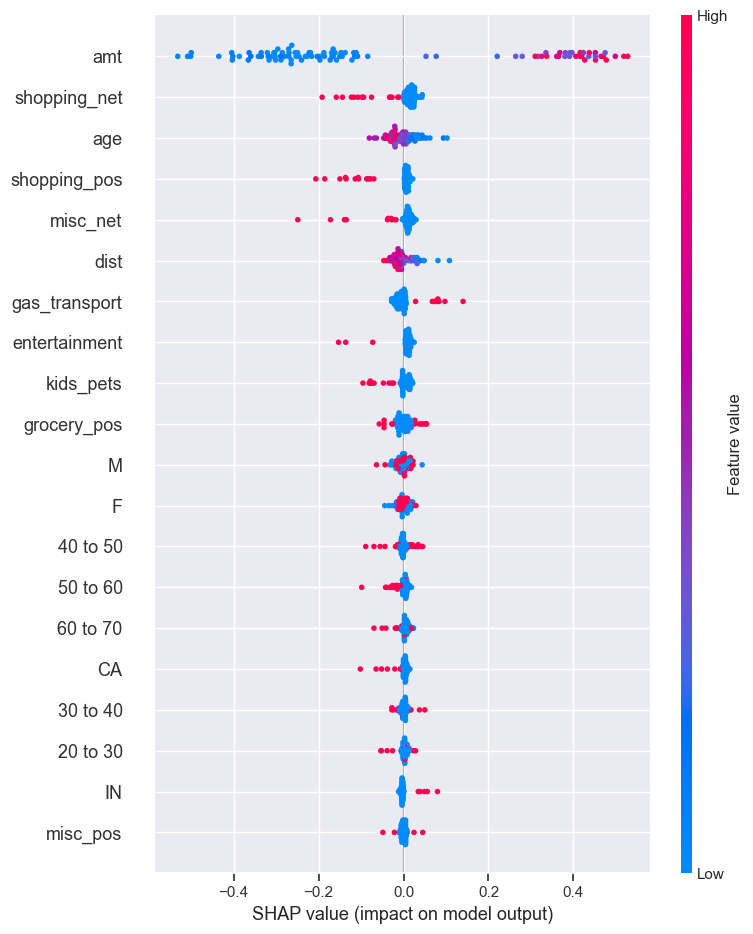

In [46]:
shap.summary_plot(shap_values.squeeze(), X_test[:idx+2].squeeze(), feature_names=features)

#### Force Plot

[How to use Shapley Additive Explanations for Black Box Machine Learning Algorithms](https://www.youtube.com/watch?v=7wnG6Wnm2uU)

In [47]:
# Plot feature contributions for a prediction
shap.initjs()  # Initialize JavaScript visualization code
force_plot = shap.force_plot(explainer.expected_value[0].numpy(), 
                shap_values[idx].squeeze(), 
                X_test[idx].squeeze(), 
                feature_names=features,
                matplotlib=False)
display(force_plot)

#### Single Feature Partial Dependence Plot

[How to Build Shap Single Feature Partial Dependence Plot (PDP Plot)](https://www.youtube.com/watch?v=CgKyAlA-0wA)

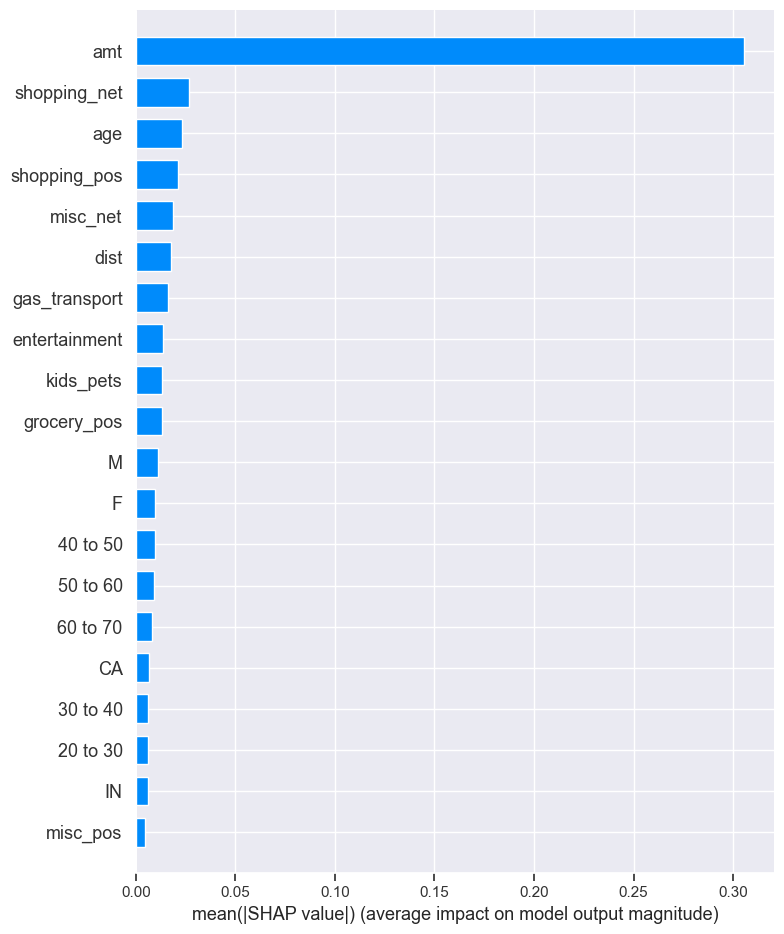

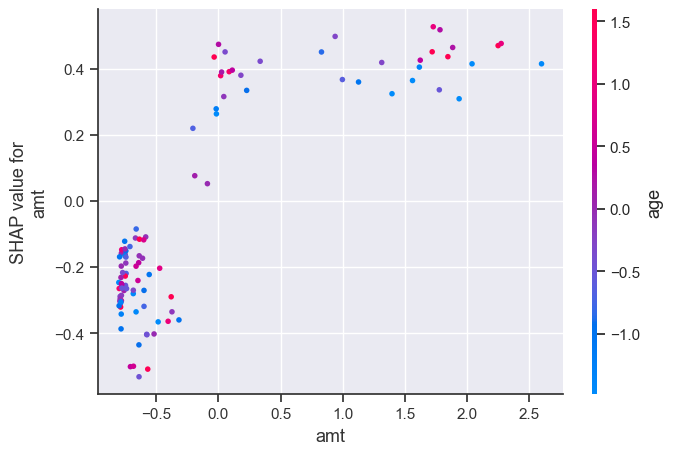

In [48]:
# Add these inside the function for more insights
shap.summary_plot(shap_values.squeeze(), 
                 X_test[:idx+2].squeeze(), 
                 feature_names=features, 
                 plot_type="bar")
plt.show()

# Dependence plot for specific feature
shap.dependence_plot("amt", 
                    shap_values.squeeze(), 
                    X_test[:idx+2].squeeze(), 
                    feature_names=features)
plt.show()

#### Verify this results wth the anomolies data to find the ground truth

# LIME